# Color contrasts 2

The fundamental problem appears to be related to an explosion in the parameter values. This is preceded by an improving loss trajectory, so the problem might be given by numerical overflow or underflow. As a first hypothesis, however, I will simply try out more gradual improvement.

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import lazytools_sflippl as lazytools
import pandas as pd
import plotnine as gg

In [5]:
dfs = []
for i in range(1, 6):
    loss_traj = np.load('../experiments/11-data/{}_loss_traj.npy'.\
                        format(i))
    df = lazytools.array_to_dataframe(loss_traj).rename(
        columns={'dim0': 'steps', 'array': 'loss'}
    )
    df['n_latents'] = np.array(i)
    dfs.append(df)

In [18]:
df_loss = pd.concat(dfs)
df_loss['step_groups'] = np.ceil((df_loss['steps']+1)/10)
df_loss = df_loss.groupby(['step_groups', 'n_latents'])['loss'].mean().reset_index()

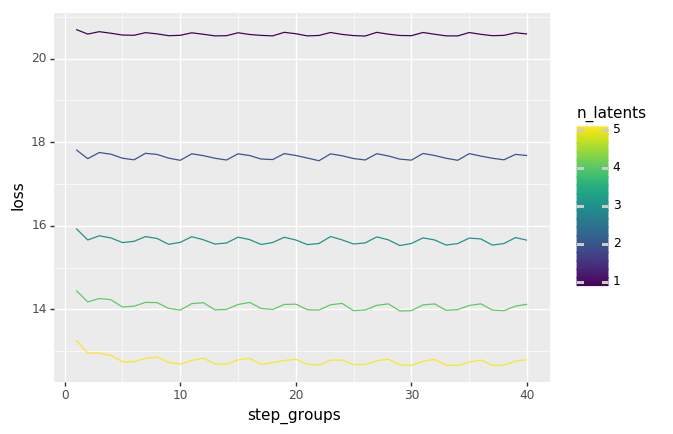

<ggplot: (-9223363244775177626)>

In [20]:
(gg.ggplot(df_loss, gg.aes(x='step_groups', y='loss', color='n_latents', group='n_latents')) + 
    gg.geom_line())

Evidently, we extract the important components rather quickly, but improve in representation with every additional component.

In [86]:
model = torch.load('../experiments/11-data/2_cpc.pt').parameters()

In [87]:
model_lst = list(model)

In [32]:
upstream_params = model_lst[0]

In [38]:
df_upstream = lazytools.array_to_dataframe(upstream_params.detach().numpy()).\
                        rename(columns={'dim0': 'component', 'dim1': 'input_dimension',
                                        'array': 'weight'})
df_upstream['n_latents'] = np.array(1)

In [40]:
df_upstream.head()

,component,input_dimension,weight,n_latents
0,0,0,-0.852709,1
1,0,1,-0.012284,1
2,0,2,-0.231093,1
3,0,3,-0.327013,1
4,0,4,-0.384899,1


In [41]:
bias_params = model_lst[1]

In [42]:
bias_params

Parameter containing:
tensor([-2.4177], requires_grad=True)

In [50]:
df_bias = lazytools.array_to_dataframe(bias_params.detach().numpy()).\
                        rename(columns={'dim0': 'component',
                                        'array': 'weight'})
df_bias['n_latents'] = np.array(1)

In [51]:
df_bias.head()

,component,weight,n_latents
0,0,-2.417716,1


In [88]:
predictor_params = model_lst[2]

In [90]:
predictor_params

Parameter containing:
tensor([[ 0.3938, -0.1608],
        [ 0.0711,  0.4009],
        [ 0.1933, -0.2024],
        [ 0.0125,  0.3115]], requires_grad=True)

In [89]:
lazytools.array_to_dataframe(predictor_params.detach().numpy())

,dim0,dim1,array
0,0,0,0.393764
1,0,1,-0.160789
2,1,0,0.071109
3,1,1,0.400853
4,2,0,0.193307
5,2,1,-0.202423
6,3,0,0.012514
7,3,1,0.311496


In [58]:
df_predictor = lazytools.array_to_dataframe(predictor_params.detach().numpy()).\
                         rename(columns={'dim0': 'channel',
                                         'dim1': 'component',
                                         'array': 'weight'})
df_predictor['n_latents'] = np.array(1)

In [59]:
df_predictor_bias = lazytools.array_to_dataframe(model_lst[3].detach().numpy()).\
                              rename(columns={'dim0': 'channel',
                                              'array': 'weight'})

In [61]:
df_predictor_bias

,channel,weight
0,0,-0.034067
1,1,-0.122627


In [92]:
model[2]

Parameter containing:
tensor([[ 0.3938, -0.1608],
        [ 0.0711,  0.4009],
        [ 0.1933, -0.2024],
        [ 0.0125,  0.3115]], requires_grad=True)

In [107]:
dfs_component = []
dfs_bias = []
dfs_predictor = []
dfs_predictor_bias = []
for i in range(1,6):
    model = list(torch.load('../experiments/11-data/{}_cpc.pt'.format(i)).parameters())
    df_upstream = lazytools.array_to_dataframe(model[0].detach().numpy()).\
                        rename(columns={'dim0': 'component', 'dim1': 'input_dimension',
                                        'array': 'weight'})
    df_upstream['n_latents'] = np.array(i)
    dfs_component.append(df_upstream)
    df_bias = lazytools.array_to_dataframe(model[1].detach().numpy()).\
                        rename(columns={'dim0': 'component',
                                        'array': 'weight'})
    df_bias['n_latents'] = np.array(i)
    dfs_bias.append(df_bias)
    df_predictor = lazytools.array_to_dataframe(model[2].detach().numpy().reshape(i, 2, i)).\
                             rename(columns={'dim0': 'component',
                                             'dim1': 'channel',
                                             'dim2': 'future_component',
                                             'array': 'weight'})
    df_predictor['n_latents'] = np.array(i)
    dfs_predictor.append(df_predictor)
    df_predictor_bias = lazytools.array_to_dataframe(model[3].detach().numpy()).\
                                  rename(columns={'dim0': 'channel',
                                                  'array': 'weight'})
    df_predictor_bias['n_latents'] = np.array(i)
    dfs_predictor_bias.append(df_predictor_bias)

In [108]:
df_component = pd.concat(dfs_component)
df_predictor = pd.concat(dfs_predictor).rename(columns={'weight': 'predictor'})
df_overall = df_component.merge(df_predictor, on=['component', 'n_latents'])

In [109]:
df_overall.head()

,component,input_dimension,weight,n_latents,channel,future_component,predictor
0,0,0,-0.852709,1,0,0,0.248305
1,0,0,-0.852709,1,1,0,0.155723
2,0,1,-0.012284,1,0,0,0.248305
3,0,1,-0.012284,1,1,0,0.155723
4,0,2,-0.231093,1,0,0,0.248305


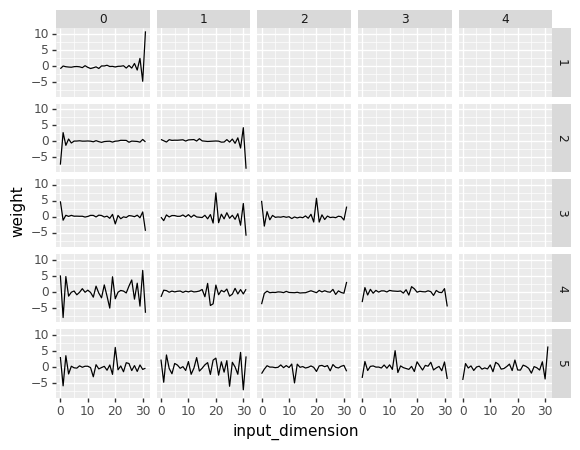

<ggplot: (-9223363244922460356)>

In [110]:
(gg.ggplot(df_overall, gg.aes(x='input_dimension', y='weight')) +
    gg.geom_line() +
    gg.facet_grid(['n_latents', 'component']))

An important next component would be self-predictive contrastive coding. This seems like Gabor filters though, essentially.

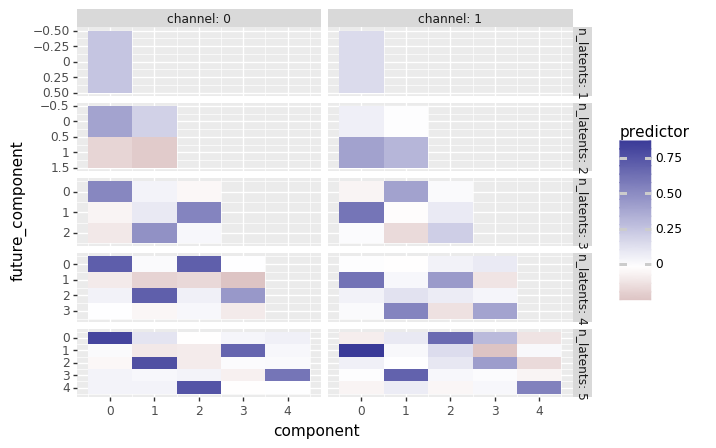

<ggplot: (8791932930501)>

In [116]:
(gg.ggplot(df_predictor, gg.aes(x='component', y='future_component', fill='predictor')) +
    gg.geom_tile() +
    gg.facet_grid(['n_latents', 'channel'], labeller='label_both', scales='free') +
    gg.scale_y_reverse() + 
    gg.scale_fill_gradient2())